# [Nflows package](https://github.com/bayesiains/nflows)
In this notebook we will go through the basic usage of [this](https://github.com/bayesiains/nflows) excellent package.

In [1]:
# The first step is to install the package into our collaboratory environment
%%capture
!pip install nflows

In [2]:
# Basic imports
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.optim as optim
import sklearn.datasets
import numpy as np

# These are the most important modules for us to work with
from nflows import flows, transforms, distributions
# These give access to some handy utilities (some of which you probably also normally write yourself)
from nflows.utils import torchutils

In [3]:
# With this package it is much simpler to set the default device to be the GPU if it is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')

In [4]:
# We are going to use the same dataset as the last notebook
from torch.utils.data import Dataset

class PlaneDataset(Dataset):
    def __init__(self, num_points, flip_axes=False):
        self.num_points = num_points
        self.flip_axes = flip_axes
        self.data = None
        self.reset()

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return self.num_points

    def reset(self):
        self._create_data()
        if self.flip_axes:
            x1 = self.data[:, 0]
            x2 = self.data[:, 1]
            self.data = torch.stack([x2, x1]).t()

    def _create_data(self):
        raise NotImplementedError


class CrescentDataset(PlaneDataset):
    def _create_data(self):
        self.bounded = False
        x1 = torch.randn(self.num_points)
        x2_mean = 0.5 * x1 ** 2 - 1
        x2_var = torch.exp(torch.Tensor([-2]))
        x2 = x2_mean + x2_var ** 0.5 * torch.randn(self.num_points)
        self.data = torch.stack((x2, x1)).t()

In [5]:
# The same simple utility for plotting 2D histograms as before
def plot2Dhist(data, bins=50, bounds=None):
    fig, ax = plt.subplots(1, figsize=(5,5))
    data = data.detach().cpu().numpy()
    x = data[:, 0]
    y = data[:, 1]
    count, xbins, ybins = np.histogram2d(x, y, bins=bins)
    count[count == 0] = np.nan
    ax.imshow(count.T,
              origin='lower', aspect='auto',
              extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()],
              )

In [6]:
ndata = int(1e5)
dataset = CrescentDataset(ndata)
# The data is accessed through .data
data = dataset.data

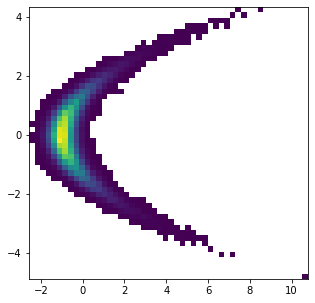

In [7]:
# Visualize the dataset again
plot2Dhist(data)

## Building the flow
As in the last notebook, and as in standard neural networks, we need to define a set of composable transformations to build the INN that forms our flow.

The method [CompositeTransform](https://github.com/bayesiains/nflows/blob/639c3a771d57c29a27c307140cc94a1008ee9f55/nflows/transforms/base.py#L32) takes a list of transformations - in this case [MaskedPiecewiseRationalQuadraticAutoregressiveTransform](https://github.com/bayesiains/nflows/blob/639c3a771d57c29a27c307140cc94a1008ee9f55/nflows/transforms/autoregressive.py#L404) and [ReversePermutation](https://github.com/bayesiains/nflows/blob/639c3a771d57c29a27c307140cc94a1008ee9f55/nflows/transforms/permutations.py#L57) - and returns an object with *forward* and *inverse* methods which form a *_cascade* of transformations pointing from the data distribution to the base distribution in the *forward* direction.

Some further information about the classes:

[MaskedPiecewiseRationalQuadraticAutoregressiveTransform](https://github.com/bayesiains/nflows/blob/639c3a771d57c29a27c307140cc94a1008ee9f55/nflows/transforms/autoregressive.py#L404) - this is a [neural spline flow](https://arxiv.org/pdf/1906.04032.pdf) and it takes the following arguments

```
"""
    Parameters:
    features : the number of input features
    hidden_features : the number of hidden features in each layer of the network that learns the spline variables
    context_features : The number of context features that will be passed to the INN
    num_bins : The number of knots to use in the spline
    tail_bound : The spline part of neural splines are only defined on a restricted
                 domain, this sets the boundaries of that domain. If the data you are working on only has finite
                 support then set this bound to that support.
    tails : Outside of the region defined by the above bound we have to apply some
            transformation to the data, at present only 'linear' transformations are
            available - where the data is not transformed at all. The default value of None 
            means that no data outside of the defined bound can be passed, and also the 
            derivative on the boundary doesn't need to be fixed. When possible passing
            None for this argument is preferable.
    num_blocks : The number of transformations to stack in the transformation that learns the spline transformation
    use_residual_blocks : Defaults to True, defines whether to use residual blocks to learn the spline transformation
"""
```



In [8]:
number_of_nodes = 5
data_dimension = 2
# Note that the dataset we are using is not bounded, and so we have to set a tail bound
tailbound = 4
# To data outside of the bounded region we will apply no transformation
oob_function = 'linear'
transformation = transforms.CompositeTransform([transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(data_dimension, number_of_nodes, tails=oob_function, tail_bound=tailbound),
                                                transforms.ReversePermutation(data_dimension),
                                                transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(data_dimension, number_of_nodes, tails=oob_function, tail_bound=tailbound),
                                                transforms.ReversePermutation(2),
                                                transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(data_dimension, number_of_nodes, tails=oob_function, tail_bound=tailbound)])

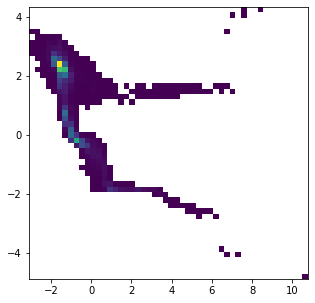

In [9]:
# Let's visualize how our INN is intialized, note that the forward method of transformation returns both the output and the log determinant of the Jacobian of the transformation
output, log_det = transformation(data)
plot2Dhist(output)

## Base distribution definition
Now we can define the other part of our flow - the base distribution to which we wish to transform.

For this we will use the [standard normal](https://github.com/bayesiains/nflows/blob/639c3a771d57c29a27c307140cc94a1008ee9f55/nflows/distributions/normal.py#L11) distribution. This takes the data shape as input.

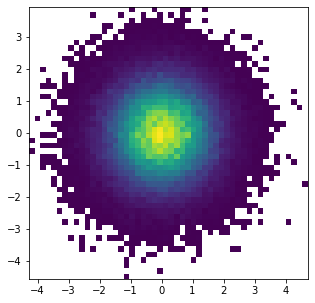

In [10]:
baseDistribution = distributions.StandardNormal([2])
plot2Dhist(baseDistribution.sample(int(1e5)))

## Define the flow object
Now all that is left to do is define the flow object which we can use to train. This is done by defining an object with [flows.Flow](https://github.com/bayesiains/nflows/blob/639c3a771d57c29a27c307140cc94a1008ee9f55/nflows/flows/base.py#L10), this takes as input a transformation - built with transformations that subclasses [Transform](https://github.com/bayesiains/nflows/blob/639c3a771d57c29a27c307140cc94a1008ee9f55/nflows/transforms/base.py#L22) - and a distribution - that subclasses [Distribution](https://github.com/bayesiains/nflows/blob/639c3a771d57c29a27c307140cc94a1008ee9f55/nflows/distributions/base.py#L16). 

Objects of type [Transform](https://github.com/bayesiains/nflows/blob/639c3a771d57c29a27c307140cc94a1008ee9f55/nflows/transforms/base.py#L22) must implement *forward* and *inverse* methods that return the transformation (a tensor of the same dimension as the input) in the specified direction as well as the log determinant evaluated at the input point. 

Objects of type [Distribution](https://github.com/bayesiains/nflows/blob/639c3a771d57c29a27c307140cc94a1008ee9f55/nflows/distributions/base.py#L16) must implement *_sample* and *_log_prob* methods that return a sample (tensor of input dimension and given batch and number of samples) and the log probability at a given input respectively.

This class implementation nicely captures the fact that flows are defined by

- a transformation for which we can evaluate the log determinant of the Jacobian and it's inverse, and

- a base distribution for which we can calculate the log probability of a given point, and from which we can sample.

Objects of type [flows.Flow](https://github.com/bayesiains/nflows/blob/639c3a771d57c29a27c307140cc94a1008ee9f55/nflows/flows/base.py#L10) subclass [Distribution](https://github.com/bayesiains/nflows/blob/639c3a771d57c29a27c307140cc94a1008ee9f55/nflows/distributions/base.py#L16), this also makes sense, as flows **define** a distribution. On top of the methods from *Distribution*, objects of type *flows.Flow* have a *transform_to_noise* method - otherwise their semantics are identical. 

The key method of *flows.Flow* objects is of course *log_prob* which we call to access the log probability of data samples under the flow during training.

In [11]:
# Define a flow object
flow = flows.Flow(transformation, baseDistribution)

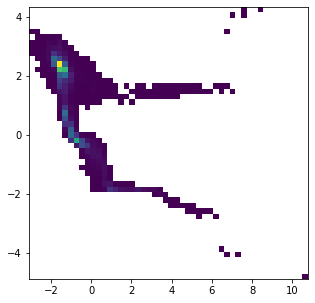

In [12]:
# Transform the data to noise
plot2Dhist(flow.transform_to_noise(data))

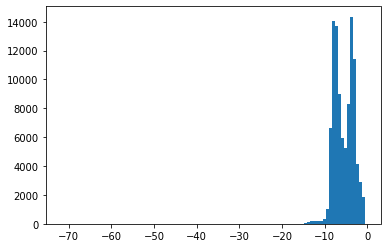

In [13]:
# Calculate the log probability of all of the data points
logprob = flow.log_prob(data)
plt.hist(torchutils.tensor2numpy(logprob), bins=100);

# Train the flow
Now we have defined all of the necessary objects we can proceed with training our flow model.

In [14]:
# Define a method that trains a flow
def train_flow(flow, n_epochs, training_data, optimizer):

        for epoch in range(n_epochs):

            running_loss = 0.0
            for i, data in enumerate(training_data, 0):

                # zero the parameter gradients
                optimizer.zero_grad()

                # Here we access the log probability of the flow
                loss = -flow.log_prob(data).mean()
                # Here we backpropogate
                loss.backward()
                # Here we update our parameters
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 200 == 199:  # print every 2000 mini-batches
                    print('[{}, {}] loss: {}'.format(epoch + 1, i + 1, running_loss))

In [15]:
n_epochs = 5
optimizer = optim.Adam(flow.parameters(), lr=0.001)
bsize = 100

training_data = torch.utils.data.DataLoader(dataset, batch_size=bsize,
                                              shuffle=True)
train_flow(flow, n_epochs, training_data, optimizer)

[1, 200] loss: 530.4863972663879
[1, 400] loss: 940.7026644945145
[1, 600] loss: 1332.0217125415802
[1, 800] loss: 1719.8724261522293
[1, 1000] loss: 2101.18771648407
[2, 200] loss: 379.7759552001953
[2, 400] loss: 753.7555713653564
[2, 600] loss: 1126.4046256542206
[2, 800] loss: 1502.874427318573
[2, 1000] loss: 1878.6465879678726
[3, 200] loss: 372.76802706718445
[3, 400] loss: 746.2516233921051
[3, 600] loss: 1119.4946630001068
[3, 800] loss: 1491.7405778169632
[3, 1000] loss: 1864.7453408241272
[4, 200] loss: 371.6265653371811
[4, 400] loss: 742.5851083993912
[4, 600] loss: 1117.1302835941315
[4, 800] loss: 1489.1663156747818
[4, 1000] loss: 1861.3005583286285
[5, 200] loss: 370.77158868312836
[5, 400] loss: 744.5392652750015
[5, 600] loss: 1117.039356827736
[5, 800] loss: 1487.3168742656708
[5, 1000] loss: 1857.3015710115433


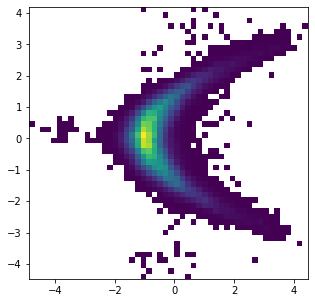

In [16]:
# To visualise the flows performance we would like to sample from it, to help with the efficiency of this calculation we turn off the automatic gradient tracking.
with torch.no_grad():
  post_training_sample = flow.sample(int(1e5))
plot2Dhist(post_training_sample)

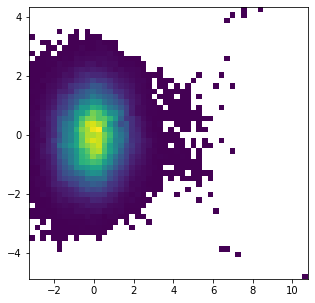

In [17]:
# We can also view how well our trained flow matches the base distribution
with torch.no_grad():
  post_training_noise_dist = flow.transform_to_noise(dataset.data)
plot2Dhist(post_training_noise_dist)

In [18]:
# Finally, just for fun, we can see how many parameters our flow has
torchutils.get_num_parameters(flow)

1449

We can see that we do much better than in the previous notebook, and without a large number of parameters. However, the tail bounds obviously cause a bit of a problem. An easy way to get around this is to add one affine transformation into the mix. To see how easy this is to do, let's construct a new flow and train it.

In [20]:
number_of_nodes = 5
data_dimension = 2
# Note that the dataset we are using is not bounded, and so we have to set a tail bound
tailbound = 4
# To data outside of the bounded region we will apply the above tailbound
oob_function = 'linear'
transformation = transforms.CompositeTransform([transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(data_dimension, number_of_nodes, tails=oob_function, tail_bound=tailbound),
                                                transforms.ReversePermutation(data_dimension),
                                                transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(data_dimension, number_of_nodes, tails=oob_function, tail_bound=tailbound),
                                                transforms.ReversePermutation(2),
                                                transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(data_dimension, number_of_nodes, tails=oob_function, tail_bound=tailbound),
                                                transforms.ReversePermutation(2),
                                                transforms.MaskedAffineAutoregressiveTransform(data_dimension, number_of_nodes)],
                                                )

new_flow = flows.Flow(transformation, baseDistribution)

n_epochs = 5
optimizer = optim.Adam(new_flow.parameters(), lr=0.001)
bsize = 100
train_flow(new_flow, n_epochs, training_data, optimizer)

[1, 200] loss: 506.4721714258194
[1, 400] loss: 916.0344951152802
[1, 600] loss: 1309.0532586574554
[1, 800] loss: 1690.9163677692413
[1, 1000] loss: 2073.7986847162247
[2, 200] loss: 379.05073845386505
[2, 400] loss: 751.8483672142029
[2, 600] loss: 1129.7663403749466
[2, 800] loss: 1502.6680208444595
[2, 1000] loss: 1873.7133818864822
[3, 200] loss: 371.71897780895233
[3, 400] loss: 742.3298162221909
[3, 600] loss: 1114.8294903039932
[3, 800] loss: 1486.9699848890305
[3, 1000] loss: 1857.9463676214218
[4, 200] loss: 369.66897785663605
[4, 400] loss: 740.302774310112
[4, 600] loss: 1108.9229446649551
[4, 800] loss: 1481.8745421171188
[4, 1000] loss: 1852.2019176483154
[5, 200] loss: 369.5640528202057
[5, 400] loss: 739.8452874422073
[5, 600] loss: 1109.5185911655426
[5, 800] loss: 1481.1340752840042
[5, 1000] loss: 1849.7343978881836


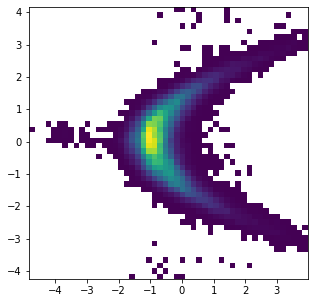

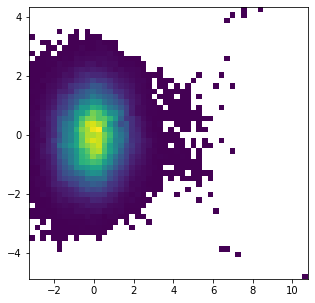

In [21]:
# To visualise the flows performance we would like to sample from it, to help with the efficiency of this calculation we turn off the automatic gradient tracking.
with torch.no_grad():
  post_training_sample = flow.sample(int(1e5))
  post_training_noise_dist = flow.transform_to_noise(dataset.data)
plot2Dhist(post_training_sample)
plot2Dhist(post_training_noise_dist)

# Adding context to the flow

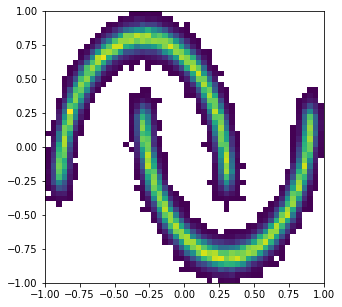

In [22]:
# In this we will load the two moons dataset and scale it to be between zero and one
def scale_axis(axis, min, max):
    normalized = (axis - min) / (max - min)
    bounded = (normalized - 1 / 2) * 2
    return bounded


# A simple way to get scaled tensors from a scikit-learn dataset
def get_data(nsample, dtype=torch.float32):
    x, y = sklearn.datasets.make_moons(nsample, noise=0.05)
    xdata = torch.tensor(x, dtype=dtype)
    sf = [[xdata[:, 0].min(), xdata[:, 0].max()], [xdata[:, 1].min(), xdata[:, 1].max()]]
    xdata[:, 0] = scale_axis(xdata[:, 0], *sf[0])
    xdata[:, 1] = scale_axis(xdata[:, 1], *sf[1])
    return xdata, torch.tensor(y, dtype=dtype)


# The training dataset
ntrain = int(1e5)
# make moons returns a label as well as data
x_train, labels_train = get_data(ntrain)

# Plot the data on which we will train
plot2Dhist(x_train)

In [23]:
# Make a simple wrapper for the data we have just created
class twoMoons(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    # This will return both data and a label when we use a pytorch dataloader
    def __getitem__(self, item):
        return self.data[item], self.labels[item]

    def __len__(self):
        return self.data.shape[0]

twomoons_data = twoMoons(x_train, labels_train)

In [24]:
# We can also make a new train loop, note this only changes in two places
def train_contextual_flow(flow, n_epochs, training_data, optimizer):

        for epoch in range(n_epochs):

            running_loss = 0.0
            for i, batches in enumerate(training_data, 0):
                # We make one change here, where we get both a 2D vector and a label
                data, label = batches

                # zero the parameter gradients
                optimizer.zero_grad()

                # And the second change is here, where we pass a context to our flow
                # Note: the label must be reshaped to be used as context
                loss = -flow.log_prob(data, context=label.view(-1, 1)).mean()
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 200 == 199:  # print every 2000 mini-batches
                    print('[{}, {}] loss: {}'.format(epoch + 1, i + 1, running_loss))

In [25]:
# Adding context with an autoregressive flow is easy, our context is a one dimensional label, and so we simply tell our transformation how it is, and then pass the context during training
number_of_nodes = 5
data_dimension = 2
# Note that the dataset we are using is not bounded, and so we have to set a tail bound
tailbound = 1.1
# To data outside of the bounded region we will apply the above tailbound
oob_function = 'linear'
transformation = transforms.CompositeTransform([transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(data_dimension, number_of_nodes, tails=oob_function, tail_bound=tailbound, context_features=1),
                                                transforms.ReversePermutation(data_dimension),
                                                transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(data_dimension, number_of_nodes, tails=oob_function, tail_bound=tailbound, context_features=1),
                                                transforms.ReversePermutation(2),
                                                transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(data_dimension, number_of_nodes, tails=oob_function, tail_bound=tailbound, context_features=1),
                                                transforms.ReversePermutation(2),
                                                transforms.MaskedAffineAutoregressiveTransform(data_dimension, number_of_nodes, context_features=1)],
                                                )

# The base distribution we have defined already accepts a context argument, and so no change is required there
context_flow = flows.Flow(transformation, baseDistribution)

n_epochs = 5
optimizer = optim.Adam(context_flow.parameters(), lr=0.001)
bsize = 100
training_data_context = torch.utils.data.DataLoader(twomoons_data, batch_size=bsize, shuffle=True)
train_contextual_flow(context_flow, n_epochs, training_data_context, optimizer)

[1, 200] loss: 393.84473299980164
[1, 400] loss: 571.6069326102734
[1, 600] loss: 608.2192688281648
[1, 800] loss: 565.3094358376693
[1, 1000] loss: 487.05778738181107
[2, 200] loss: -96.70216873288155
[2, 400] loss: -212.07992893457413
[2, 600] loss: -335.1885967552662
[2, 800] loss: -467.9049751460552
[2, 1000] loss: -604.1531278789043
[3, 200] loss: -140.36870688199997
[3, 400] loss: -283.2636306285858
[3, 600] loss: -429.46266037225723
[3, 800] loss: -578.6613154411316
[3, 1000] loss: -731.3222532272339
[4, 200] loss: -151.8495079278946
[4, 400] loss: -307.33014193177223
[4, 600] loss: -461.78177431225777
[4, 800] loss: -616.1223293840885
[4, 1000] loss: -772.982742100954
[5, 200] loss: -158.5906800031662
[5, 400] loss: -316.1320803761482
[5, 600] loss: -474.01463481783867
[5, 800] loss: -630.4130030572414
[5, 1000] loss: -788.8749965131283


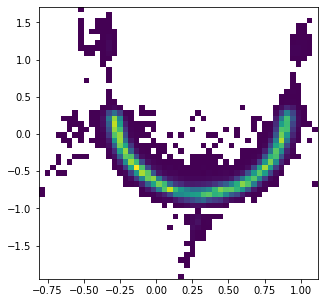

In [26]:
# We can generate one of the moons
nsample = int(1e5)
with torch.no_grad():
  post_training_sample = context_flow.sample(1, context=torch.ones((int(nsample), 1)) ).view(-1, 2)
plot2Dhist(post_training_sample)

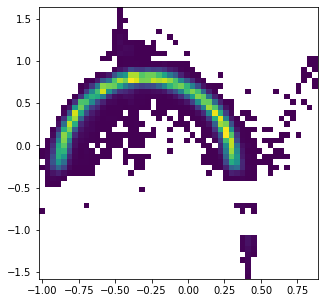

In [27]:
# And the other
nsample = int(1e5)
with torch.no_grad():
  post_training_sample = context_flow.sample(1, context=torch.zeros((int(nsample), 1)) ).view(-1, 2)
plot2Dhist(post_training_sample)

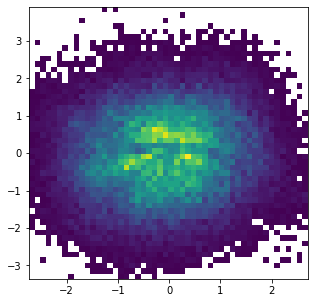

In [28]:
# Both of the moons map to our base distribution
nsample = int(1e5)
label = 1
with torch.no_grad():
  dt, ll = twomoons_data[twomoons_data.labels == label]
  post_training_noise_dist = context_flow.transform_to_noise(dt, context=ll.view(-1, 1))
plot2Dhist(post_training_noise_dist)

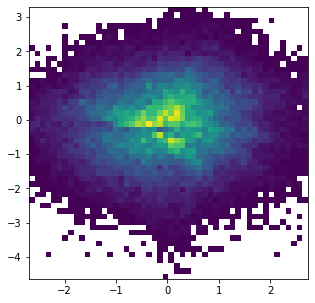

In [29]:
# Both of the moons map to our base distribution
nsample = int(1e5)
label = 0
with torch.no_grad():
  dt, ll = twomoons_data[twomoons_data.labels == label]
  post_training_noise_dist = context_flow.transform_to_noise(dt, context=ll.view(-1, 1))
plot2Dhist(post_training_noise_dist)

Conditional coupling flows with MLPs. Here we have to implement an MLP ourselves, the nflows package does not provide this functionality

In [30]:
# Define a dense network that takes a context argument in it's forward definition
# This layer is not user friendly for generic tasks, but hopefully it is readable
class dense_net(nn.Module):
    def __init__(self, input_dim, output_dim, layers=[64, 64, 64], context_features=1):
        super(dense_net, self).__init__()
        self.latent_dim = output_dim
        # This is necessary for scaling the outputs to softmax when using splines
        self.hidden_features = layers[-1]

        # This defines how we include the context in our transformation
        self.context_layer = nn.Linear(context_features, layers[0])
        # This defines the transformation that we use to learn the parameters of the layers
        self.functions = nn.ModuleList([nn.Linear(input_dim, layers[0])])
        self.functions.extend(nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)]))

    # In here we can see how the context is passed to the network
    # In the first call we use our context embedding layer to expand the context to the same dimension as the first layers,
    # and then sum with the output of that layer before the activation
    def forward(self, x, context=None):
        for i, function in enumerate(self.functions[:-1]):
            x = function(x)
            if i == 0:
                x += self.context_layer(context)
            x = torch.relu(x)
        x = self.functions[-1](x)
        return x

In [31]:
# Now we make a conditional flow from coupling splines, for this we have to define a mask and a function that can be called with an input dimension and an output dimension - the dense network we just made
number_of_nodes = 5
data_dimension = 2
tailbound = 1.1
oob_function = 'linear'
# The mask defines which of the two input dimensions we select at each step of the flow
mask=[1, 0]
transformation = transforms.CompositeTransform([transforms.PiecewiseRationalQuadraticCouplingTransform(mask, dense_net, tail_bound=tailbound, tails=oob_function, apply_unconditional_transform=False),
                                                transforms.ReversePermutation(data_dimension),
                                                transforms.PiecewiseRationalQuadraticCouplingTransform(mask, dense_net, tail_bound=tailbound, tails=oob_function, apply_unconditional_transform=False),
                                                transforms.ReversePermutation(2),
                                                transforms.PiecewiseRationalQuadraticCouplingTransform(mask, dense_net, tail_bound=tailbound, tails=oob_function, apply_unconditional_transform=False),
                                                transforms.ReversePermutation(2),
                                                transforms.MaskedAffineAutoregressiveTransform(data_dimension, number_of_nodes, context_features=1),
                                                transforms.ReversePermutation(2),
                                                transforms.MaskedAffineAutoregressiveTransform(data_dimension, number_of_nodes, context_features=1)]
                                                )

# Place the transformation on the device
transformation.to(device)
# The base distribution we have defined already accepts a context argument, and so no change is required here
context_flow = flows.Flow(transformation, baseDistribution)

# Train this new flow
n_epochs = 10
optimizer = optim.Adam(context_flow.parameters(), lr=0.001)
bsize = 100
training_data_context = torch.utils.data.DataLoader(twomoons_data, batch_size=bsize, shuffle=True)
train_contextual_flow(context_flow, n_epochs, training_data_context, optimizer)

[1, 200] loss: 312.1034838920459
[1, 400] loss: 207.3095986386761
[1, 600] loss: 60.39680381026119
[1, 800] loss: -89.84294502530247
[1, 1000] loss: -243.75432030949742
[2, 200] loss: -156.16751366853714
[2, 400] loss: -312.6724430322647
[2, 600] loss: -468.248765707016
[2, 800] loss: -624.8412463665009
[2, 1000] loss: -783.8548154234886
[3, 200] loss: -159.63130402565002
[3, 400] loss: -318.7902917265892
[3, 600] loss: -478.1787264943123
[3, 800] loss: -636.298819065094
[3, 1000] loss: -796.0068751573563
[4, 200] loss: -160.7830593585968
[4, 400] loss: -320.010733127594
[4, 600] loss: -480.22685384750366
[4, 800] loss: -641.6300184130669
[4, 1000] loss: -803.3268687725067
[5, 200] loss: -161.85490328073502
[5, 400] loss: -322.7559825181961
[5, 600] loss: -483.79848724603653
[5, 800] loss: -644.4226249456406
[5, 1000] loss: -806.8474217653275
[6, 200] loss: -161.73767232894897
[6, 400] loss: -324.0583897829056
[6, 600] loss: -485.74921733140945
[6, 800] loss: -647.8042588233948
[6, 100

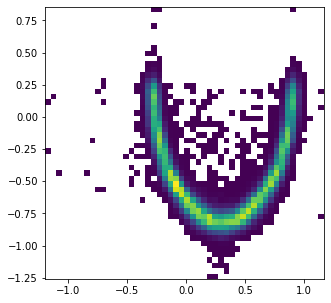

In [32]:
# And again we can generate one of the moons
nsample = int(1e5)
with torch.no_grad():
  post_training_sample = context_flow.sample(1, context=torch.ones((int(nsample), 1)) ).view(-1, 2)
plot2Dhist(post_training_sample)

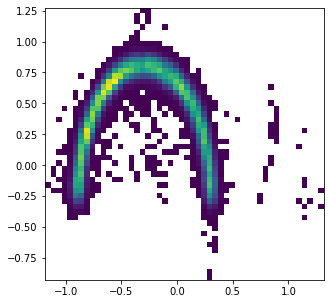

In [33]:
# And the other
nsample = int(1e5)
with torch.no_grad():
  post_training_sample = context_flow.sample(1, context=torch.zeros((int(nsample), 1)) ).view(-1, 2)
plot2Dhist(post_training_sample)

Now we are again done with everything, next it is time to try to set this up yourself.